Simulate what a curator would see when using the same model implementation but with different significant figures.

In [1]:
import numpy as np
import os
import json
import matplotlib.pyplot as plt

import sim_lib

res_dir = os.path.join('results', 'workflow_sim_2')
curator_res_dir = os.path.join(res_dir, 'curator_results_same')
fp = os.path.join(res_dir, 'sim_modeler_diff_sigfig.json')

In [2]:
with open(fp, 'r') as f:
    modeler_metadata = sim_lib.Metadata.from_json(json.load(f))

In [3]:
stochastic = modeler_metadata.simulator == 'gillespie_ssa'
t_fin = modeler_metadata.sample_times[-1]
num_steps = modeler_metadata.sample_times.shape[0]
ecf_eval_info = modeler_metadata.ecf_eval_info

var_names = list(modeler_metadata.ecf_evals.keys())

Get data from curator's implementation

In [4]:
results = dict()
sample_times = np.zeros((num_steps,))

for name in var_names:
    sample_times, results[name] = sim_lib.load_results_copasi(os.path.join(curator_res_dir, f'sim_curator_2_{name}.txt'),
                                                              2 * modeler_metadata.sample_size,
                                                              num_steps)

Show results, for reference

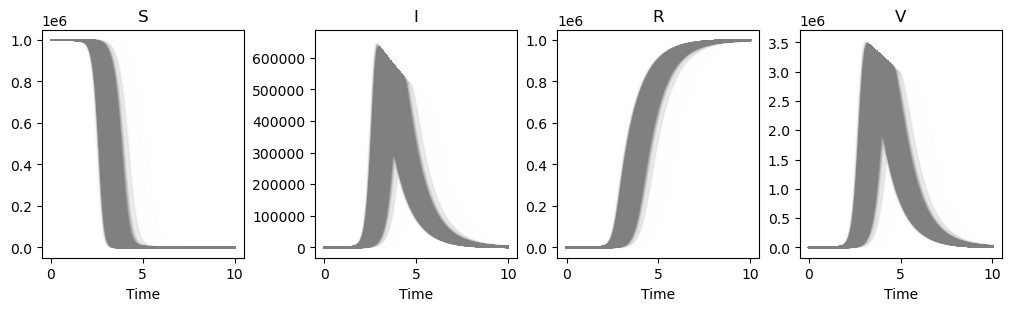

In [5]:
fig, axs = plt.subplots(1, len(var_names), figsize=(10.0, 3.0), layout='compressed')
for i, name in enumerate(var_names):
    for j in range(results[name].shape[0]):
        axs[i].plot(sample_times, results[name][j, :], alpha=0.01, color='gray')
    axs[i].set_title(name)
    axs[i].set_xlabel('Time')

Test against modeler's sampling data

In [6]:
sampling_err_thresh = 0.001
ks_stats_samp = sim_lib.test_sampling(results, err_thresh=sampling_err_thresh)[0]
print('Curator\'s statistics:', np.average(ks_stats_samp), np.std(ks_stats_samp))
print('Modeler\'s statistics:', modeler_metadata.ks_stat_mean, modeler_metadata.ks_stat_stdev)

Curator's statistics: 0.05514529480987875 0.006393056441084072
Modeler's statistics: 0.05380683523236684 0.006296675510659093


Test against modeler's data

Maximum error: 1.4335434354894183


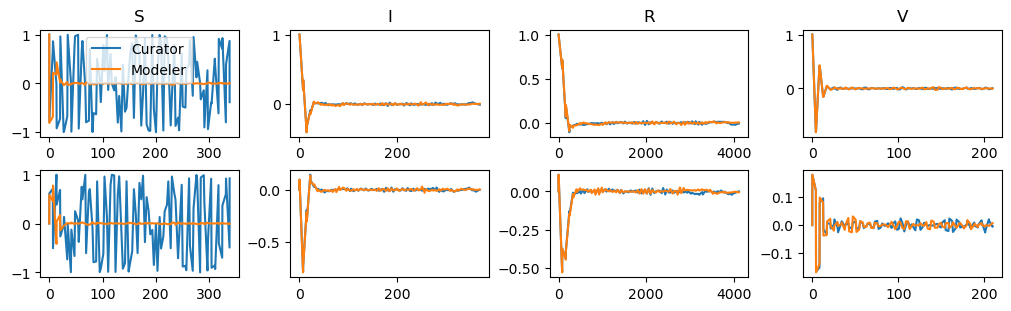

In [7]:
err_max = 0.0
res_oi_idx = 0
for name in var_names:
    for i in range(num_steps):
        eval_t = sim_lib.get_eval_info_times(*ecf_eval_info[name][i])
        ecf_curator = sim_lib.ecf(results[name][:modeler_metadata.sample_size, i], eval_t)
        err_i = sim_lib.ecf_compare(ecf_curator, modeler_metadata.ecf_evals[name][i])
        if err_i > err_max:
            res_oi_idx = int(i)
            err_max = err_i

fig, axs = plt.subplots(2, len(var_names), figsize=(10.0, 3.0), layout='compressed')
for j, name in enumerate(var_names):
    eval_t = sim_lib.get_eval_info_times(*ecf_eval_info[name][res_oi_idx])
    ecf_curator = sim_lib.ecf(results[name][:modeler_metadata.sample_size, res_oi_idx], eval_t)
    ecf_modeler = modeler_metadata.ecf_evals[name][res_oi_idx]
    for i in range(2):
        axs[i, j].plot(eval_t, ecf_curator[:, i], label='Curator')
        axs[i, j].plot(eval_t, ecf_modeler[:, i], label='Modeler')
    axs[0, j].set_title(name)
axs[0, 0].legend()

print('Maximum error:', err_max)

Record data

In [8]:
with open(os.path.join(res_dir, 'simdata_curator_fail_sigfig.json'), 'w') as f:
    json.dump(dict(sample_size=2*modeler_metadata.sample_size,
                   sampling_err_thresh=sampling_err_thresh,
                   err_max=err_max,
                   results_times=sample_times.tolist(),
                   results={n: results[n].tolist() for n in var_names},
                   ks_stats_samp=ks_stats_samp),
              f, indent=4)